In [3]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy.stats import linregress

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Snowload
---
Load data and interpolate the design value field

In [4]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
mask_path = '/home/nannau/Desktop/climpyrical/data/mask.nc'
dv = 'snw'

interp_dict = get_interpolation(mask_path, PATH, dv)
master_idx = interp_dict['idx']
iens = (interp_dict['iens'][:, master_idx])

Plot distribution.

Text(0.5, 1.0, 'KDE Distribution of snw Values')

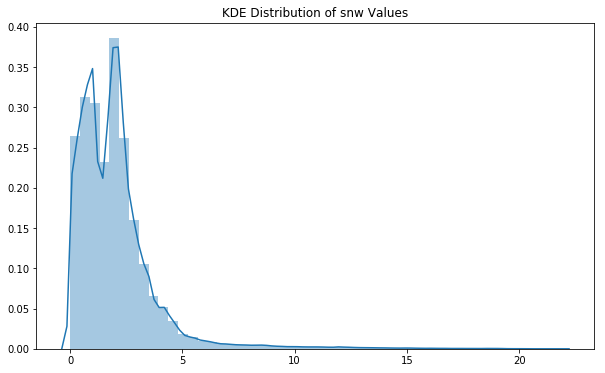

In [5]:
plt.figure(figsize=(10, 6))
sns.distplot(iens[0, ...])
plt.title('KDE Distribution of {} Values'.format(dv))

Perform singular value decomposition

In [31]:
#u, s, vT = np.linalg.svd(iens, full_matrices=False)
#del u
vT = ens_to_eof(iens.T, 25).T
vT.shape

Cluster


(25, 799963)

Calculate explained variance and plot

In [9]:
explained_variance_ratio = [s[i]/np.sum(s) for i in range(s.shape[0])]
cumulative_variance = np.cumsum(explained_variance_ratio)
component = range(s.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(component, explained_variance_ratio)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')

NameError: name 's' is not defined

Load the quantile station data

In [32]:
df = pd.read_csv('/storage/data/projects/nrc/station_data/snow_load/swe_rl50_stations_test.csv', index_col=None)
df.head()

,id,station_name,lat,lon,prov,snow_load_rl50
0,2193,EUREKA A,79.9833,-85.9333,NU,0.936965
1,2027,TUKTOYAKTUK,69.4500,-133.0000,NT,1.815147
2,2029,TUKTOYAKTUK A,69.4333,-133.0260,NT,2.158906
3,2064,BAKER LAKE A,64.2989,-96.0778,NU,3.265956
4,2072,CHESTERFIELD,63.3333,-90.7167,NU,3.314342


In [33]:
ndf = match_coords(df, interp_dict, 'snow_load_rl50')
print("There are ", ndf.shape, "real station observations to fit.")

There are  (525, 5) real station observations to fit.


#### Create the pseudo observations and regress

In [34]:
obs_idx = generate_pseudo_obs(iens, 0.0003)
print("Taking", obs_idx.shape[0], "pseudo observations")

Taking 239 pseudo observations


In [35]:
obs = iens[0, obs_idx]
eofs = vT[:, obs_idx]

print("Check that the pseudo observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', eofs.shape, '\n'
      'Matched Obs shape: ', obs.shape)

Check that the pseudo observations and the EOFs contain the same number of grids: 
EOF shape:  (25, 239) 
Matched Obs shape:  (239,)


Fit the EOFs tot he pseudo observations and predict their values

In [36]:
model = fit_eof(eofs.T, obs.flatten())
predictions = predict_dv(model, eofs.T)

Regressed model score: 0.9992924842576646 0.9992924842576646


slope 0.9992924842576663 r2_val 0.999646179534371


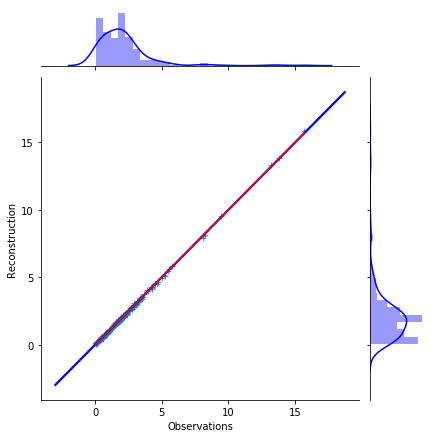

In [37]:
sns.jointplot(obs.T, predictions.T, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(obs.T, predictions.T, marker='+')
sns.lineplot(obs.T, obs.T, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(obs.T, predictions.T)
print("slope", slope, "r2_val", r_value)

#### Use the real observations and regress

In [38]:
robs_idx = ndf['matched_idx']
robs = (ndf['snow_load_rl50'].values) # fix units
reofs = vT[:, robs_idx]

In [90]:
yslopes = []
x = eofs.T

for sd in np.linspace(0, np.std(robs)):
    y = obs.flatten() + np.random.normal(0., sd, obs.flatten().shape[0])
    model = fit_eof(eofs.T, y)
    predictions = predict_dv(model, eofs.T)
    slope, intercept, r_value, p_value, std_err = linregress(y, predictions.T)
    yslopes.append(slope)


Regressed model score: 0.9992924842576646 0.9992924842576646
Regressed model score: 0.9987310720057057 0.9987310720057057
Regressed model score: 0.9976392329012923 0.9976392329012923
Regressed model score: 0.9946455338939282 0.9946455338939282
Regressed model score: 0.9916214742454972 0.9916214742454972
Regressed model score: 0.9890569223155129 0.9890569223155129
Regressed model score: 0.9831326882939251 0.9831326882939252
Regressed model score: 0.9761553408051296 0.9761553408051296
Regressed model score: 0.966824123104534 0.966824123104534
Regressed model score: 0.9628052618125423 0.9628052618125423
Regressed model score: 0.9475315730418838 0.9475315730418838
Regressed model score: 0.9421550582558387 0.9421550582558387
Regressed model score: 0.9325972706794163 0.9325972706794163
Regressed model score: 0.9214809673751494 0.9214809673751494
Regressed model score: 0.9140764865045173 0.9140764865045173
Regressed model score: 0.9039785334318619 0.9039785334318619
Regressed model score: 0.9

Text(0, 0.5, 'Slope/R$^2$ Score')

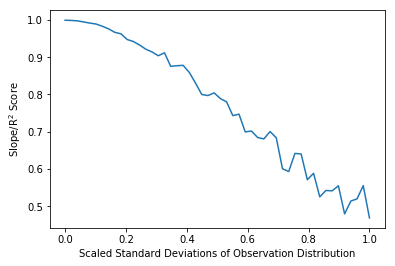

In [93]:
plt.plot(np.linspace(0, np.std(robs))/np.std(robs), yslopes)
plt.xlabel('Scaled Standard Deviations of Observation Distribution')
plt.ylabel('Slope/R$^2$ Score')

Compare the distributions of the station observations and of the models

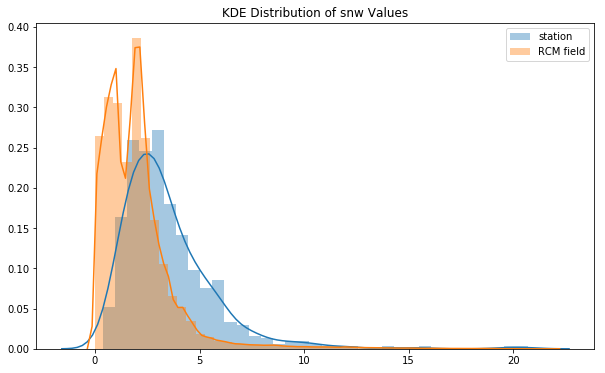

In [39]:
plt.figure(figsize=(10, 6))
plt.title('KDE Distribution of {} Values'.format(dv))
sns.distplot(robs, label='station')
sns.distplot(iens[0, ...], label='RCM field')
plt.legend()

Fit the model and predict it

In [94]:
rmodel = fit_eof(reofs.T, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs.T)

Regressed model score: 0.2578612230473101 0.2578612230473101


slope 0.2578612230473099 r2_val 0.5078003771634186
Std deviation ratio of vectors [models/]: 0.803936218627487


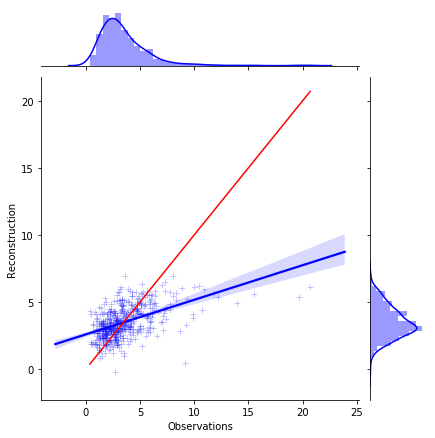

In [95]:
sns.jointplot(robs, linrpredictions, kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(robs, linrpredictions, 
                color="blue",
                marker='+',
                alpha=0.3)

sns.lineplot(robs.T, 
          robs.T,
          color='r',
            dashes=True)

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)
print("slope", slope, "r2_val", r_value)

print("Std deviation ratio of vectors [models/]:", np.mean(np.std(iens, axis=1))/np.std(robs))

In [85]:
dv_recon = interp_dict['iens'][0, ...].copy()
dv_recon[master_idx] = rmodel.predict(vT.T)

In [86]:
dv_recon_sq = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])

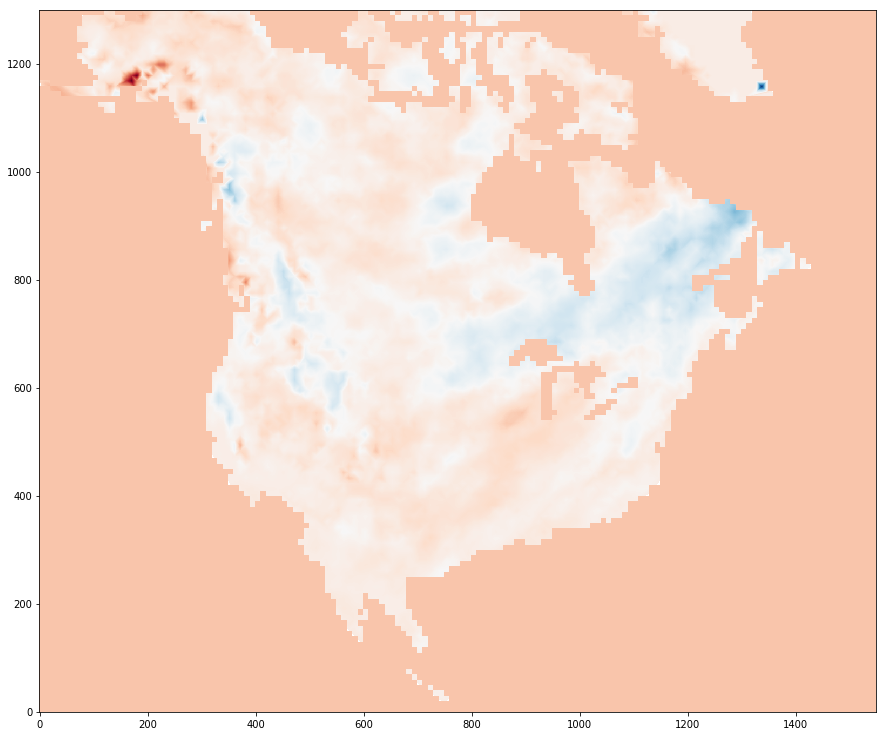

In [96]:
plt.figure(figsize=(15, 15))
plt.imshow(dv_recon_sq, cmap='RdBu')
plt.gca().invert_yaxis()